In [1]:
from demo import *
from gaming_cleaner import *

# Goals

#Import and Prepare Data

Note data sources and cite 2-3 dss
think df is from vg chartz

## Import Libraries and data

### Video game ratings data

Features are fairly straightforward, Sales is total copies sold


In [2]:
t, _ = scrape_page('http://www.vgchartz.com/games/games.php?name=super+smash+bros.+melee&keyword=&console=&region=All&developer=&publisher=&goty_year=&genre=&boxart=Both&banner=Both&ownership=Both&showmultiplat=No&results=200&order=TotalSales&showtotalsales=0&showtotalsales=1&showpublisher=0&showpublisher=1&showvgchartzscore=0&showvgchartzscore=1&shownasales=0&showdeveloper=0&showdeveloper=1&showcriticscore=0&showcriticscore=1&showpalsales=0&showreleasedate=0&showreleasedate=1&showuserscore=0&showuserscore=1&showjapansales=0&showlastupdate=0&showothersales=0&showshipped=0&showshipped=1')
t

{'Super Smash Bros. Melee-:-GC': {'pos': '1',
  'img_link': 'http://www.vgchartz.com//games/boxart/full_404087AmericaFrontccc.jpg',
  'game_url': 'http://www.vgchartz.com//games/game.php?id=2291&region=All',
  'console': 'GC',
  'publisher': 'Nintendo',
  'developer': 'HAL Laboratory',
  'vg_score': 'N/A',
  'critic_score': '9.2',
  'user_score': 'N/A',
  'shipped': '7.41m',
  'sales': 'N/A',
  'date': '02nd Dec 01'}}

### Video game cover images

desc

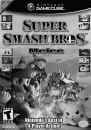

array([[195, 152, 141, ...,  10,  10,  18],
       [178, 117, 104, ...,   5,   6,  13],
       [176, 112, 101, ...,   5,   5,   9],
       ...,
       [105, 107, 130, ...,  32,  34,  33],
       [ 91,  98, 107, ...,  49,  46,  47],
       [ 75,  75,  62, ...,  57,  52,  52]], dtype=uint8)

In [3]:
#what the img data look like
url = 'http://www.vgchartz.com/games/boxart/full_404087AmericaFrontccc.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
display(img)
np.array(img)

### Video game summaries

desc

In [4]:
#what the text data look like
pull_txt_sum('http://www.vgchartz.com/game/2291/super-smash-bros-melee/?region=All')

"The All-Star brawl is on!\r\nNintendo's biggest stars are all here! Duke it out with Mario, Link, Donkey Kong, the Ice Climbers, and many more.\r\n\r\nThe craziest four-player fighting game of all time returns for a frantic, fun-filled Nintendo Gamecube melee! Pick a classic character and enter the frey.\r\nA brand-new Adventure mode takes you through classic side-scrolling worlds like the Mushroom Kingdom!\r\nChoose from over 20 stages and wage battles with tons of items, like Bob-ombs and the Super Scope.\r\nTons of custom options await, each with a wild twist. Try playing Giant Melee for a gargantuan clash!\r\nBattle through a new Coin match, fight for style points in Bonus mode, or stage a trournament with up to 64 players!\r\nUnlock cool game secrets! Take on Event Mode and fight through specific battle challenges.\r\nAs you play, collect nearly 300 detailed trophies of characters and items from throughout Nintendo's history.\r\n\r\n*Nintendo - back of box"

## Clean, explore, and prepapre/process data


### Data cleaning (and saving)

In [ ]:
#delete all current multi_batched data
import os
import glob
pths = []
chk = input('Sure? (y)')
if chk == 'y':
    pths=['dem','imgs','labels','names','text']
for pth in pths:
    files = glob.glob('data/'+pth+'/*.json')
    tvtfiles = glob.glob('data/test-val/'+pth+'/*.json')
    for f in files+tvtfiles:
        os.remove(f)

In [3]:
random.seed(42)
with open('raw_dem/games_as_200_batches.json', 'rb') as f:
    games_as_batches = json.load(f)

In [4]:
#random list that will be our test/val data
ran_ls = random.sample(range(0,39), 10)
#some stuff to store batches of games and keep track of place
mega_batches = []
multi_batch = {}
num = 0
size = 5
org_btchs = []
#for loading in text and image data
for dex, batch in enumerate(games_as_batches):
    multi_batch.update(batch)
    org_btchs.append(dex)
    #if we are at the specified new batch size or end of list, create a big batch and save
    if (dex+1) % size == 0 or (dex+1) == len(games_as_batches):
        #num not in ran_ls sets if the batch is in testing set
        #make the big batch
        big_batch = clean_batch(org_btchs, multi_batch, num, num not in ran_ls)
        #save the demographic data, name, and labels
        big_batch.save_data(['d','l','n'])
        #delete demographic data and labels as they are now saved
        big_batch.clear_data(['d'])
        
        #append it to our new list of mega batches
        #at this point we are just appending a list of names in order to manage memory
        mega_batches.append(big_batch)
        
        #increase number for saving name
        #ready for next mega batch we make
        num+=1
        multi_batch = {}
        org_btchs = []
    
#training data
training = [b for b in mega_batches if b.train_data] 
#testing data
testing = [b for b in mega_batches if not b.train_data]
#clear some ram
games_as_batches, multi_batch, mega_batches = None, None, None

In [7]:
#cleaning image data
#make a Random Projection model to reduce dimensionality, more detail in library
ISPR = SparseRandomProjection(n_components=100)
#wrapper function to train decomposer with bathces
ISPR = batch_train_decomposer('raw_imgs/', ISPR, [b.org_btchs for b in training], tr_img, 'img_ISPR')

Finished 1 in 29.1408 sec
['models/img_ISPR2.joblib']
Finished 11 in 363.9373 sec
['models/img_ISPR2.joblib']
Finished 21 in 708.465 sec
['models/img_ISPR2.joblib']
['models/img_ISPR2.joblib']
img_ISPR2 made


In [13]:
#now to actually reduce dimensionality and store image features
for mega_batch in training:
    mb_imgs = load_batches('raw_imgs/', mega_batch.org_btchs)
    mega_batch.decompose_data(mb_imgs, ISPR, 'i', tr_img)
    mega_batch.save_data(['i'])
    mega_batch.clear_data(['i'])
mb_igms = None
#beyond dimensions being reduced, each batch is now only 1 mb

In [14]:
#cleaning text data, much easier but this is not an in depth approach
#this is all the training batch numbers together, text is much less memory intensive
all_training_btchs = [b for bs in training for b in bs.org_btchs]
#this is all training text data after processing through tr_txt (eliminate stop words, punctuation, and stem words)
all_text = {nm:tr_txt(t) for nm, t in load_batches('raw_text/', all_training_btchs).items()}

In [15]:
#vectorize data
CNTV = CountVectorizer(min_df=2)
#fit data to model to get word vectors as rows
CNTV_data = CNTV.fit_transform(all_text.values())
dump(CNTV, 'models/txt_CNTV.joblib')
#fit the latent Dirichilet allocation
LDA = LatentDirichletAllocation(n_components=100)
LDA_data = LDA.fit(CNTV_data)
dump(LDA, 'models/txt_LDA.joblib')

['models/txt_LDA2.joblib']

In [7]:
#simple class to feed in both transforms at once
class dual_mod():
    def transform(d):
        return LDA.transform(CNTV.transform(d))

In [17]:
#now to actually reduce dimensionality and store text features    
DM = dual_mod
for mega_batch in training:
    mb_txt = {nm:all_text[nm] for nm in mega_batch.nms}
    mega_batch.decompose_data(mb_txt, DM, 't')
    mega_batch.save_data(['t'])
    mega_batch.clear_data(['t'])

In [5]:
ISPR = load('models/img_ISPR.joblib')
CNTV = load('models/txt_CNTV.joblib')
LDA = load('models/txt_LDA.joblib')
all_testing_btchs = [b for bs in testing for b in bs.org_btchs]
all_text = {nm:tr_txt(t) for nm, t in load_batches('raw_text/', all_testing_btchs).items()}

In [8]:
#same thing but on testing
DM = dual_mod
for mega_batch in testing:
    #img first
    mb_imgs = load_batches('raw_imgs/', mega_batch.org_btchs)
    mega_batch.decompose_data(mb_imgs, ISPR, 'i', tr_img)
    mega_batch.save_data(['i'])
    mega_batch.clear_data(['i'])
    mb_igms = None
    mb_txt = {nm:all_text[nm] for nm in mega_batch.nms}
    mega_batch.decompose_data(mb_txt, DM, 't')
    mega_batch.save_data(['t'])
    mega_batch.clear_data(['t'])

### Saving Testing/Validating Sets

In [43]:
import pandas as pd
tid_cols = ['feat_'+str(i) for i in range(100)]+['name','label']
ttd_cols = ['feat_'+str(i) for i in range(100)]+['name','label']
tdd_cols = ['developer','score0','img_link','date','pos','console','link','publisher','score1','score2','name','label']

In [44]:
#save everything to 3 big data sets
train_img_df = pd.DataFrame(columns=tid_cols)
train_txt_df = pd.DataFrame(columns=ttd_cols)
train_dem_df = pd.DataFrame(columns=tdd_cols)

for typ,df in {'imgs/img':train_img_df,'text/txt':train_txt_df,'dem/dem':train_dem_df}.items():
    for mb in training:
        with open('data/'+typ+'_batch_'+str(mb.btch_num)+'.json', 'rb') as f:
            data = json.load(f)
        data = np.append(data, [[n] for n in mb.nms], 1)
        data = np.append(data, [[n] for n in mb.labels], 1).tolist()
        pd_data = pd.DataFrame(data,columns=df.columns)
        df = df.append(pd_data, ignore_index=True)
    df.to_csv('train_'+typ[-3:]+'.csv')

In [46]:
#and same for testing
test_img_df = pd.DataFrame(columns=tid_cols)
test_txt_df = pd.DataFrame(columns=ttd_cols)
test_dem_df = pd.DataFrame(columns=tdd_cols)

for typ,df in {'imgs/img':test_img_df,'text/txt':test_txt_df,'dem/dem':test_dem_df}.items():
    for mb in testing:
        with open('data/test-val/'+typ+'_batch_'+str(mb.btch_num)+'.json', 'rb') as f:
            data = json.load(f)
        data = np.append(data, [[n] for n in mb.nms], 1)
        data = np.append(data, [[n] for n in mb.labels], 1).tolist()
        pd_data = pd.DataFrame(data,columns=df.columns)
        df = df.append(pd_data, ignore_index=True)
    df.to_csv('test_'+typ[-3:]+'.csv')

In [ ]:
#other notes
#stochstic gradient descent is trainig on batches and updating weights each time we ahve to use this
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
#batch gradietn descent is training on all data at once
#https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html
#highly specialized function to hpyer param cv train NNS with tf.estimators
#things to CV, learning rate (three), otpimizer (two), activation function (maybe two), 